# Fraud Data Analysis
## Setup

In [ ]:
import os
import sys
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from scipy.stats import spearmanr
from collections import Counter
from plotly import graph_objects as go
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from collections import defaultdict

sns.set(style="whitegrid")
%matplotlib inline

# File paths
FEATURES_CSV = "../features/anomaly_scores_gnn.csv"
LABELS_CSV = "../data/raw/wallets_classes.csv" 
LLM_INSIGHTS_JSON = "../results/llm_insights.json"
METRICS_JSON = "../results/runtime_cost_log.json"
GNN_PREDICTIONS_JSON = "../results/gnn_predictions.json"

# Feature Columns
FEATURE_COLUMNS = [
    "degree", "in_degree", "out_degree",  # Graph structure
    "num_txs_as_sender", "num_txs_as_receiver", "total_txs",
    "lifetime_in_blocks", "num_timesteps_appeared_in",
    "btc_transacted_total", "btc_transacted_mean", "btc_transacted_median",
    "btc_sent_total", "btc_sent_mean", "btc_sent_median",
    "btc_received_total", "btc_received_mean", "btc_received_median",
    "fees_total", "fees_mean", "fees_median",
    "blocks_btwn_txs_mean", "blocks_btwn_input_txs_mean", "blocks_btwn_output_txs_mean",
    "num_addr_transacted_multiple", "transacted_w_address_mean"
]

# quick asserts
for p in [FEATURES_CSV, LABELS_CSV, LLM_INSIGHTS_JSON, METRICS_JSON]:
    if not Path(p).exists():
        print(f"[WARN] File not found: {p}  (some analysis cells will skip)")


## Load Data

In [62]:
features_df = pd.read_csv(FEATURES_CSV)
labels_df = pd.read_csv(LABELS_CSV) if Path(LABELS_CSV).exists() else pd.DataFrame()
llm_insights = json.load(open(LLM_INSIGHTS_JSON)) if Path(LLM_INSIGHTS_JSON).exists() else {}
metrics = pd.read_json(METRICS_JSON) if Path(METRICS_JSON).exists() else pd.DataFrame()

# Normalize label column names: your sample had "ddress" (typo) -> try to find the id & class columns
labels_df.columns = [c.strip() for c in labels_df.columns]
if "address" not in labels_df.columns and "ddress" in labels_df.columns:
    labels_df = labels_df.rename(columns={"ddress": "address"})
if "class" not in labels_df.columns:
    # try lower-cased alternatives
    candidates = [c for c in labels_df.columns if c.lower() in ("class","label","y")]
    if candidates:
        labels_df = labels_df.rename(columns={candidates[0]: "class"})

print("features_df.shape:", features_df.shape)
print("labels_df.shape:", labels_df.shape)
print("llm_insights entries:", len(llm_insights))
print("metrics rows:", len(metrics))


C:\Users\Owner\AppData\Local\Temp\ipykernel_20172\2730251315.py:1: DtypeWarning:

Columns (5,62) have mixed types. Specify dtype option on import or set low_memory=False.



features_df.shape: (1026711, 64)
labels_df.shape: (822942, 2)
llm_insights entries: 250
metrics rows: 250


## GNN Validation

In [63]:
# Load the full JSON as a single dict
with open(LLM_INSIGHTS_JSON, "r") as f:
    llm_raw = json.load(f)

print("Loaded LLM entries:", len(llm_raw))

# Convert to DataFrame: extract consensus info
llm_rows = []
for node_id, entry in llm_raw.items():
    cons = entry.get("llm_output_structured", {}).get("consensus", {})
    if cons:
        llm_rows.append({
            "address": cons.get("node_id", node_id),
            "llm_fraud": int(cons.get("is_fraud", 0)),
            "llm_confidence": cons.get("avg_confidence", None),
            "llm_fraud_type": cons.get("fraud_type", None)
        })

df_llm = pd.DataFrame(llm_rows)
df_llm["address"] = df_llm["address"].astype(str)

# Use GNN anomaly score to define fraud prediction
threshold = np.percentile(features_df["anomaly_score"], 98)  # top 3% as fraud
features_df["gnn_fraud"] = (features_df["anomaly_score"] >= threshold).astype(int)

# Merge all data into a single DataFrame for analysis
df_all = features_df.merge(df_llm, on='address', how='left')
if not labels_df.empty:
    df_all = df_all.merge(labels_df, on='address', how='left')
print("Combined df_all.shape:", df_all.shape)
df_all.head()

Loaded LLM entries: 250
Combined df_all.shape: (1026711, 69)


,degree,in_degree,out_degree,node_type,type,address,Time_step,num_txs_as_sender,num_txs_as_receiver,first_block_appeared_in,...,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median,node,anomaly_score,gnn_fraud,llm_fraud,llm_confidence,llm_fraud_type,class
0,25,0,0,unknown,wallet,111112TykSw72ztDN2WJger4cynzWYC5w,25.0,0.0,1.0,439586.0,...,1.0,1.0,1.0,111112TykSw72ztDN2WJger4cynzWYC5w,4.086016,0,NaN,NaN,NaN,2.0
1,16,0,0,unknown,wallet,1111DAYXhoxZx2tsRnzimfozo783x1yC2,48.0,0.0,8.0,439589.0,...,1.0,1.0,1.0,1111DAYXhoxZx2tsRnzimfozo783x1yC2,14.449889,1,NaN,NaN,NaN,3.0
2,2,0,0,unknown,wallet,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,21.0,0.0,1.0,431522.0,...,1.0,1.0,1.0,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,0.241970,0,NaN,NaN,NaN,2.0
3,6,0,0,unknown,wallet,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,17.0,1.0,1.0,423456.0,...,1.0,1.0,1.0,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,-0.016092,0,NaN,NaN,NaN,3.0
4,6,0,0,unknown,wallet,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,20.0,0.0,1.0,429513.0,...,1.0,1.0,1.0,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,-0.644900,0,NaN,NaN,NaN,2.0


In [64]:
# Only nodes with LLM predictions
df_llm_nonnull = df_all[df_all['llm_fraud'].notnull()].copy()

# Map class labels to binary (1 = illicit, 0 = licit)
# For unknown (3), we can leave as NaN or exclude
df_llm_nonnull['class_binary'] = df_llm_nonnull['class'].map({1:1, 2:0})

# Exclude unknown labels for accuracy calculation
df_labels_eval = df_llm_nonnull[df_llm_nonnull['class'].isin([1,2])].copy()
df_labels_eval['class_binary'] = (df_labels_eval['class'] == 1).astype(int)

gnn_vs_labels_acc = (df_labels_eval['gnn_fraud'] == df_labels_eval['class_binary']).mean()
llm_vs_labels_acc = (df_labels_eval['llm_fraud'] == df_labels_eval['class_binary']).mean()

print(f"GNN vs labels accuracy: {gnn_vs_labels_acc:.2f}")
print(f"LLM vs labels accuracy: {llm_vs_labels_acc:.2f}")

df_llm_nonnull['gnn_llm_agree'] = df_llm_nonnull['gnn_fraud'] == df_llm_nonnull['llm_fraud']
gnn_llm_agreement_rate = df_llm_nonnull['gnn_llm_agree'].mean()

print(f"GNN vs LLM agreement rate (75 nodes): {gnn_llm_agreement_rate:.2f}")


GNN vs labels accuracy: 0.75
LLM vs labels accuracy: 0.07
GNN vs LLM agreement rate (75 nodes): 0.30


## XAI Faithfulness

In [65]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

explainer_scores_path = "../results/explainer_scores.json"
if Path(explainer_scores_path).exists():
    expl_json = json.load(open(explainer_scores_path))
    # expl_json[node_id] = {feat: {explainer: score, ...}, ...}
    # We'll build per-feature global importance by averaging GraphLIME scores across nodes
    gl_avgs = {}
    for nid, featdict in expl_json.items():
        for feat, scores in featdict.items():
            gl_avgs.setdefault(feat, []).append(scores.get('graphlime', 0.0) or 0.0)
    gl_mean = {feat: np.mean(vals) for feat, vals in gl_avgs.items()}
    gl_mean_series = pd.Series(gl_mean).sort_values(ascending=False)
    display(gl_mean_series.head(10))
else:
    print("[WARN] explainer_scores.json not found — skipping global explainer summary.")

# Fit global ridge to predict anomaly score from features, then compare coefficient magnitudes with graphlime means
# Use node_features_full computed earlier (features_df/merged). We'll use features_df (if it has FEATURE_COLUMNS).
FEATURE_COLUMNS_SUBSET = [c for c in FEATURE_COLUMNS if c in features_df.columns]
if len(FEATURE_COLUMNS_SUBSET) == 0:
    print("[WARN] No FEATURE_COLUMNS in features_df to fit surrogate model.")
else:
    X = features_df[FEATURE_COLUMNS_SUBSET].fillna(0).values
    y = -features_df['anomaly_score'].values  # invert if lower=more anomalous
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    reg = Ridge(alpha=1.0)
    reg.fit(Xs, y)
    coef_abs = np.abs(reg.coef_)
    coef_series = pd.Series(coef_abs, index=FEATURE_COLUMNS_SUBSET).sort_values(ascending=False)
    display(coef_series.head(10))

    # Compare top features by reg coef vs graphlime means (if available)
    if Path(explainer_scores_path).exists():
        common = list(set(coef_series.index) & set(gl_mean_series.index))
        if len(common) >= 3:
            coef_common = coef_series.loc[common].reindex(common)
            gl_common = gl_mean_series.loc[common].reindex(common)
            cor, p = spearmanr(coef_common.values, gl_common.values)
            print(f"Spearman correlation (global reg coef vs GraphLIME mean) on common features: {cor:.3f}, p={p:.3e}")
        else:
            print("Not enough common features to compute correlation.")



btc_sent_total               0.991736
total_txs                    0.990123
btc_sent_mean                0.949809
btc_received_total           0.874147
btc_received_median          0.869887
fees_mean                    0.845577
btc_transacted_median        0.835791
btc_transacted_mean          0.830401
num_timesteps_appeared_in    0.807148
degree                       0.799010
dtype: float64

btc_transacted_mean      2.077507
btc_transacted_median    1.557472
fees_mean                0.947747
fees_median              0.892783
btc_sent_median          0.635112
btc_received_median      0.629647
btc_sent_mean            0.307497
btc_received_mean        0.289990
total_txs                0.242280
lifetime_in_blocks       0.212101
dtype: float64

Spearman correlation (global reg coef vs GraphLIME mean) on common features: 0.497, p=1.347e-02


## LLM Validation

In [66]:
if Path(LLM_INSIGHTS_JSON).exists():
    insights = json.load(open(LLM_INSIGHTS_JSON))
    rows = []
    for nid, info in insights.items():
        cons = info.get("llm_output_structured", {}).get("consensus", {})
        rows.append({
            "node": nid,
            "is_fraud_consensus": cons.get("is_fraud"),
            "fraud_type": cons.get("fraud_type"),
            "agreement_rate": cons.get("agreement_rate", info.get("agreement_rate", np.nan)),
            "avg_confidence": cons.get("avg_confidence", info.get("avg_confidence", np.nan)),
        })
    llm_df = pd.DataFrame(rows)
    print("LLM consensus rows:", len(llm_df))
    display(llm_df.head())

    # merge with labels & gnn if available
    merged_llm = llm_df.merge(features_df[['node','anomaly_score']], left_on='node', right_on='node', how='left')
    if not labels_df.empty:
        merged_llm = merged_llm.merge(labels_df[['address','class']], left_on='node', right_on='address', how='left')
        merged_llm['label_bin'] = merged_llm['class'].map({1:1,2:0,3:np.nan})

    # Compare LLM consensus vs label (if available)
    if 'label_bin' in merged_llm.columns and merged_llm['label_bin'].notnull().any():
        comp = merged_llm.dropna(subset=['label_bin','is_fraud_consensus'])
        comp['is_fraud_consensus_bin'] = comp['is_fraud_consensus'].astype(int)
        print("LLM vs true labels (summary):")
        print("Precision:", precision_score(comp['label_bin'], comp['is_fraud_consensus_bin'], zero_division=0))
        print("Recall:", recall_score(comp['label_bin'], comp['is_fraud_consensus_bin'], zero_division=0))
        print("F1:", f1_score(comp['label_bin'], comp['is_fraud_consensus_bin'], zero_division=0))
        print("Confusion matrix:")
        print(confusion_matrix(comp['label_bin'], comp['is_fraud_consensus_bin']))
    else:
        print("No ground-truth labels available for LLM comparison in the merge.")
else:
    print("[WARN] llm_insights.json missing — skipping LLM analysis.")


LLM consensus rows: 250


,node,is_fraud_consensus,fraud_type,agreement_rate,avg_confidence
0,37U1BcQvTAfgkSJnFegekjdKJ5SFUAg4Hy,True,money laundering,0.8,0.68
1,139AdCGDyaF1Yg4Eyddvaj38PnihsfCLPj,True,money laundering,0.4,0.36
2,1BKhEsYKhw5FD4pJ6f7JstobjjRFuqQ2YD,True,money laundering,1.0,0.89
3,12ZjbeFDGtUboK73gshp2EKp8effFEJ7Qf,True,money laundering,0.2,0.34
4,39ioEbcSHDDgLJsvzQWb9QLRBobQi9ovCi,True,money laundering,0.6,0.51


LLM vs true labels (summary):
Precision: 0.0
Recall: 0.0
F1: 0.0
Confusion matrix:
[[ 7 96]
 [ 0  0]]


C:\Users\Owner\AppData\Local\Temp\ipykernel_20172\2130644700.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



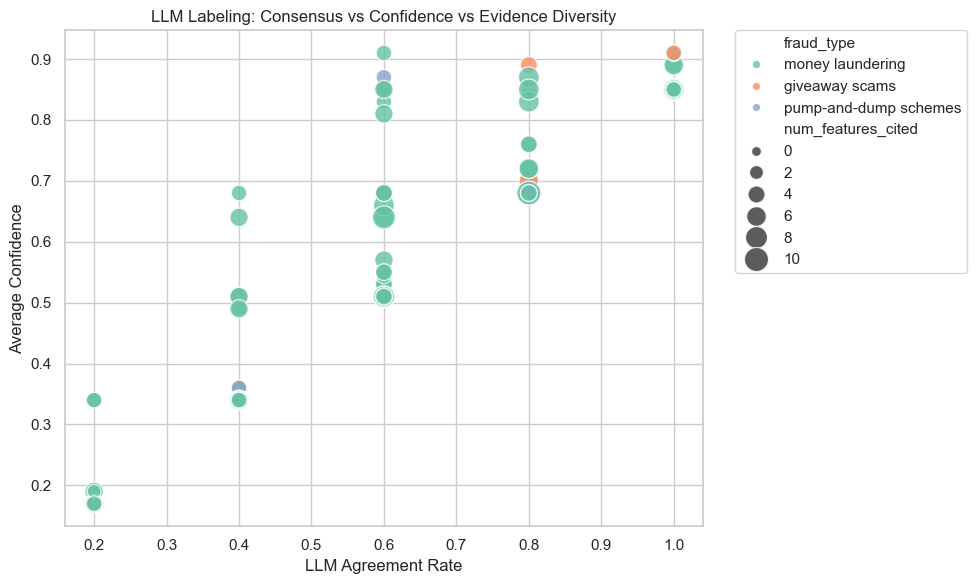

In [67]:
merged_llm['num_features_cited'] = merged_llm['node'].map(lambda nid: len(set(
    f for s in insights[nid]['llm_output_structured']['samples'] 
    for f in s.get('evidence', {}).get('features', [])
)))

merged_llm['num_behaviors_cited'] = merged_llm['node'].map(lambda nid: len(set(
    b for s in insights[nid]['llm_output_structured']['samples'] 
    for b in s.get('evidence', {}).get('behaviors', [])
)))

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=merged_llm,
    x='agreement_rate',
    y='avg_confidence',
    size='num_features_cited',
    hue='fraud_type',       # or 'label_bin' for true labels
    palette='Set2',
    sizes=(50, 300),
    alpha=0.8
)
plt.xlabel("LLM Agreement Rate")
plt.ylabel("Average Confidence")
plt.title("LLM Labeling: Consensus vs Confidence vs Evidence Diversity")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()


In [121]:
feature_name_map = {
    "btc_sent_mean": "BTC Sent (Mean)",
    "total_txs": "Total Transactions",
    "btc_sent_total": "BTC Sent (Total)",
    "fees_mean": "Fees (Mean)",
    "btc_received_median": "BTC Received (Median)",
    "btc_received_total": "BTC Received (Total)",
    "degree": "Degree",
    "num_timesteps_appeared_in": "Timesteps Appeared",
    "btc_transacted_mean": "BTC Transacted (Mean)",
    "btc_transacted_median": "BTC Transacted (Median)",
    "num_txs_as_sender": "Transactions as Sender",
    "num_txs_as_receiver": "Transactions as Receiver",
    "btc_transacted_total": "BTC Transacted (Total)",
    "blocks_btwn_txs_mean": "Blocks Between Transactions (Mean)",
    "num_addr_transacted_multiple": "Addresses Transacted Multiple Times"
}

# Build the dataframe
rows = []
for nid, info in insights.items():
    consensus = info.get("llm_output_structured", {}).get("consensus", {})
    fraud_type = consensus.get("fraud_type")
    if fraud_type is None:
        continue

    samples = info.get("llm_output_structured", {}).get("samples", [])
    for s in samples:
        feats = s.get("evidence", {}).get("features", [])
        for feat in feats:
            if feat == "anomaly_score":  # exclude this feature
                continue
            rows.append((fraud_type, feat))

df = pd.DataFrame(rows, columns=["fraud_type", "feature"])

# Count frequencies
freq = df.groupby(["fraud_type", "feature"]).size().reset_index(name="count")

# Select top N features overall
N = 10
top_features = freq.groupby('feature')['count'].sum().sort_values(ascending=False).head(N).index
plot_df = freq[freq["feature"].isin(top_features)].copy()

# Map to readable labels
plot_df["Evidence Feature"] = plot_df["feature"].map(feature_name_map).fillna(plot_df["feature"])
plot_df.rename(columns={
    "fraud_type": "Fraud Category",
    "count": "Influence / Mentions"
}, inplace=True)

# Prepare nodes for Sankey
features = plot_df["Evidence Feature"].unique().tolist()
frauds = plot_df["Fraud Category"].unique().tolist()
nodes = features + frauds

# Map names to indices
node_indices = {name: i for i, name in enumerate(nodes)}

# Prepare links
links = {
    "source": plot_df["Evidence Feature"].map(node_indices),
    "target": plot_df["Fraud Category"].map(node_indices),
    "value": plot_df["Influence / Mentions"]
}

# Create Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        label=nodes,
        pad=15,
        thickness=20,
        color=["lightblue"]*len(features) + ["salmon"]*len(frauds)
    ),
    link=links
))

fig.update_layout(title_text="GraphLIME Feature Influence on LLM Fraud Classification", font_size=12)
fig.show()


## Feature Classification

In [69]:
rows = []
for nid, info in insights.items():
    samples = info.get("llm_output_structured", {}).get("samples", [])
    for s in samples:
        fraud_type = s.get("fraud_type")
        if not fraud_type:
            continue
        evidence_feats = s.get("evidence", {}).get("features", [])
        row = {feat: 1 for feat in evidence_feats}  # features seen = 1
        row['fraud_type'] = fraud_type
        rows.append(row)

df_tree = pd.DataFrame(rows).fillna(0)  # missing features → 0
df_tree.head()


,degree,btc_sent_total,anomaly_score,fraud_type,blocks_btwn_output_txs_mean,num_txs_as_sender,blocks_btwn_txs_mean,btc_transacted_median,transacted_w_address_mean,num_addr_transacted_multiple,...,btc_sent_mean,lifetime_in_blocks,fees_mean,btc_transacted_mean,total_txs,in_degree,out_degree,btc_sent_median,fees_median,blocks_btwn_txs_total
0,1.0,1.0,1.0,money laundering,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,money laundering,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,money laundering,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,money laundering,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,money laundering,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
X = df_tree.drop(columns='fraud_type')
y = df_tree['fraud_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

clf = DecisionTreeClassifier(max_depth=3)  # shallow tree for interpretability
clf.fit(X_train, y_train)

# Text-based tree
tree_rules = export_text(clf, feature_names=list(X.columns))
print(tree_rules)


|--- btc_received_total <= 0.50
|   |--- btc_transacted_total <= 0.50
|   |   |--- blocks_btwn_txs_mean <= 0.50
|   |   |   |--- class: money laundering
|   |   |--- blocks_btwn_txs_mean >  0.50
|   |   |   |--- class: money laundering
|   |--- btc_transacted_total >  0.50
|   |   |--- num_txs_as_sender <= 0.50
|   |   |   |--- class: money laundering
|   |   |--- num_txs_as_sender >  0.50
|   |   |   |--- class: money laundering
|--- btc_received_total >  0.50
|   |--- num_timesteps_appeared_in <= 0.50
|   |   |--- num_txs_as_sender <= 0.50
|   |   |   |--- class: money laundering
|   |   |--- num_txs_as_sender >  0.50
|   |   |   |--- class: money laundering
|   |--- num_timesteps_appeared_in >  0.50
|   |   |--- blocks_btwn_input_txs_mean <= 0.50
|   |   |   |--- class: giveaway scams
|   |   |--- blocks_btwn_input_txs_mean >  0.50
|   |   |   |--- class: money laundering



In [71]:
# Model performance statistics
y_pred = clf.predict(X_test)

print("\n=== Decision Tree Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix as DataFrame
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in clf.classes_],
                         columns=[f"pred_{c}" for c in clf.classes_])
print("\nConfusion Matrix:")
print(cm_df)

# Tree structure stats
print("\n=== Tree Structure ===")
print("Max depth:", clf.get_depth())
print("Number of leaves:", clf.get_n_leaves())

# Feature Importances
fi = pd.DataFrame({
    "feature": X.columns,
    "importance": clf.feature_importances_
}).sort_values("importance", ascending=False)

print("\nFeature Importances:")
print(fi)



=== Decision Tree Performance ===
Accuracy: 0.8

Classification Report:
                       precision    recall  f1-score   support

       giveaway scams       0.00      0.00      0.00         6
     money laundering       0.80      1.00      0.89        52
pump-and-dump schemes       0.00      0.00      0.00         7

             accuracy                           0.80        65
            macro avg       0.27      0.33      0.30        65
         weighted avg       0.64      0.80      0.71        65


Confusion Matrix:
                            pred_giveaway scams  pred_impersonation scams  \
true_giveaway scams                           0                         0   
true_impersonation scams                      0                         0   
true_money laundering                         0                         0   
true_pump-and-dump schemes                    0                         0   

                            pred_money laundering  pred_pump-and-dump schemes 

## Cost and Latency Table

In [72]:
if not metrics.empty:
    # metrics may be list of dicts, ensure DataFrame
    if isinstance(metrics, list):
        metrics_df = pd.DataFrame(metrics)
    else:
        metrics_df = metrics.copy()

    # drop rows where explainer_time_s is zero (setup costs)
    metrics_df = metrics_df[metrics_df['explainer_time_s'] > 0].copy()

    # basic stats
    summary = metrics_df[['gnn_time_s','explainer_time_s','llm_latency_s','llm_cost_usd','llm_input_tokens','llm_output_tokens','total_time_s']].agg(['count','mean','median','sum']).T
    display(summary)


,count,mean,median,sum
gnn_time_s,201.0,920.678800,917.469679,1.850564e+05
explainer_time_s,201.0,2642.829118,2605.738732,5.312087e+05
llm_latency_s,201.0,4.085882,3.588394,8.212623e+02
llm_cost_usd,201.0,0.001247,0.001245,2.506041e-01
llm_input_tokens,201.0,5411.592040,5420.000000,1.087730e+06
llm_output_tokens,201.0,725.079602,721.000000,1.457410e+05
total_time_s,201.0,2663.280634,2629.415038,5.353194e+05


## Save

In [73]:
OUT_DIR = "analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# save merged GNN+labels summary
merged.to_csv(os.path.join(OUT_DIR, "gnn_with_labels.csv"), index=False)

# save llm consensus merge if computed
if 'merged_llm' in globals():
    merged_llm.to_csv(os.path.join(OUT_DIR, "llm_consensus_summary.csv"), index=False)

# save metrics subset
if not metrics.empty:
    metrics_df.to_csv(os.path.join(OUT_DIR, "runtime_metrics_clean.csv"), index=False)

print("Saved summary CSVs to", OUT_DIR)


NameError: name 'merged' is not defined